In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_profiling

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
cwd = os.getcwd()
maindir = os.path.dirname(cwd)
print(maindir)

filepath = os.path.join(maindir,'data/external')
#os.listdir(filepath)

/Users/maureenkeenan/Desktop/Kaggle/WiDs_Datathon_2020


In [3]:
df = pd.read_csv(os.path.join(filepath,'training_v2.csv'))
df.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Columns: 186 entries, encounter_id to apache_2_bodysystem
dtypes: float64(170), int64(8), object(8)
memory usage: 130.1+ MB


In [5]:
# Look at our target variable: hospital_death
df.groupby('hospital_death').hospital_death.count()

hospital_death
0    83798
1     7915
Name: hospital_death, dtype: int64

In [6]:
7915/83798

0.09445332824172414

In [7]:
# Change this to text to use with Seaborn
lgd = dict({0:'Survived',1:'Died'})
df['Survived'] = df['hospital_death'].map(lgd)

In [8]:
# Look through the data for number of unique values. 
vals = df.nunique()
vals[vals < 3]
vals[(vals > 2) & (vals < 10)]
vals[(vals > 10) & (vals < 200)]
vals[vals > 200].sort_values()

d1_temp_min                209
h1_hco3_max                214
d1_hco3_max                223
d1_sysbp_invasive_max      225
icu_id                     241
                         ...  
pre_icu_los_days          9757
urineoutput_apache       24772
bmi                      34888
patient_id               91713
encounter_id             91713
Length: 78, dtype: int64

####  Unique values at a df level aren't super helpful here as many patients will have their own values . Let's look at columns with null data. 

In [9]:
nas=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)/len(df),columns = ['percent'])
pos = (nas['percent'] >= 0.2) & (nas['percent'] < 0.3)
nas[pos]

,percent
wbc_apache,0.240010
h1_temp_max,0.236957
h1_temp_min,0.236957
hospital_admit_source,0.233435
hematocrit_apache,0.216741
bun_apache,0.210025
creatinine_apache,0.205565
sodium_apache,0.202807


#### Look for columns that are mostly empty

>90%     : bilirubin, lactate, albumin
<br/> 80 - 90% : h1_pao2fio2ratio, arterial_ph, hco3, arterial pco2, wbc, arterial_po2, calcium, platelets,bun, creatinine, diasbp_invasive, sysbp_invasive, mbp, invasive, hematocrit
<br/> 70 - 80% : hemaglobin, sodium, potassium, ph_apache, pao2_apache, paco2_for_ph_apache, fio2_apache, paco2_apache, diasbp_invasive, sysbp_invasive, mbp_invasive, d1_pao2fio2ratio
<br/> ** Note ** all of the apache scores have the same missing values
<br/> 60 - 70% : arterial_ph, arterial_pco2, arterial_po2, bilirubin_apache, inr both h1 and d1
<br/> 50 - 60% : albumin_apache, bilirubin, glucose, albumin, urineoutput_apache
<br/> 30 - 50% : no columns
<br/> 20 - 30% : wbc_apache, temp, hosptial_admit_source, hematocrit_apache, bun_apache, creatinine_apache, sodium_apache
<br/> 10 - 20% : all d1 vitals: hco3, platelets, wbc, calcium, hemaglobin, hematocrit, glucose apache, bun, sodium, creatininte, potassium

####  Empty columns can be grouped

* Top missing data is from h1_vitals. Here 'h1' means it was taken during their first hour in the stay. 'd1' is during the first 24 hours. 
    - It could be intersting to look if the patients have both h1 and d1, which may mean two measurements. Check if they are the same. 
    - It could also be that some hospitals take vitals within the hour or that having an h1 score at all means a condition is more serious

* Invasive measures and lab blood gas are also typically missing. THis makes sense and is probably only required for certain conditions.



In [10]:
# Use the categories from the provided dictionary to look at the data in groups
categories = pd.read_csv(os.path.join(filepath,'WiDS Datathon 2020 Dictionary.csv'))
print(categories['Category'].unique())

identifier = categories[categories['Category']=='identifier']['Variable Name'].tolist()
demographic = categories[categories['Category']=='demographic']['Variable Name'].tolist()

# Fix error in demographic. It includes 'icu_admit_type' which is not in the table
demographic.remove('icu_admit_type')

Acov = categories[categories['Category']=='APACHE covariate']['Variable Name'].tolist()
vitals = categories[categories['Category']=='vitals']['Variable Name'].tolist()

labs = categories[categories['Category']=='labs']['Variable Name'].tolist()
lab_bg = categories[categories['Category']=='lab blood gas']['Variable Name'].tolist()

Apredict = categories[categories['Category']=='APACHE prediction']['Variable Name'].tolist()
Acom = categories[categories['Category']=='APACHE comorbidity']['Variable Name'].tolist()

Agroup = categories[categories['Category']=='APACHE group']['Variable Name'].tolist()
GOSSIS = categories[categories['Category']=='GOSSIS example prediction']['Variable Name'].tolist()


['identifier' 'demographic' 'APACHE covariate' 'vitals' 'labs'
 'labs blood gas' 'APACHE prediction' 'APACHE comorbidity'
 'APACHE grouping' 'GOSSIS example prediction']


In [11]:
# df[demographic]

In [12]:
# Look at summary statistics for each grouping
df[demographic].describe().T

,count,mean,std,min,25%,50%,75%,max
hospital_death,91713.0,0.086302,0.280811,0.000000,0.000000,0.000000,0.000000,1.000000
age,87485.0,62.309516,16.775119,16.000000,52.000000,65.000000,75.000000,89.000000
bmi,88284.0,29.185818,8.275142,14.844926,23.641975,27.654655,32.930206,67.814990
elective_surgery,91713.0,0.183736,0.387271,0.000000,0.000000,0.000000,0.000000,1.000000
height,90379.0,169.641588,10.795378,137.200000,162.500000,170.100000,177.800000,195.590000
icu_id,91713.0,508.357692,228.989661,82.000000,369.000000,504.000000,679.000000,927.000000
pre_icu_los_days,91713.0,0.835766,2.487756,-24.947222,0.035417,0.138889,0.409028,159.090972
readmission_status,91713.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
weight,88993.0,84.028340,25.011497,38.600000,66.800000,80.300000,97.100000,186.000000


In [13]:
# Check outliers
test_df = df[demographic]
nas=pd.DataFrame(test_df.isnull().sum().sort_values(ascending=False)/len(test_df),columns = ['percent'])
pos = (nas['percent'] >= 0)
nas[pos]

,percent
hospital_admit_source,0.233435
age,0.046100
bmi,0.037388
weight,0.029658
ethnicity,0.015210
height,0.014545
icu_admit_source,0.001221
gender,0.000273
readmission_status,0.000000
pre_icu_los_days,0.000000


### Start collecting data for first save file

* Keep identifier data. 
* Address NaN in demogrpahic data
* Keep and address data in APACHE grouping and GOSSIS

In [14]:
# Keep identifier data. 

# Recall from above that both encounter_id and patient_id are unique identifiers. Drop one. 
df = df.drop(columns = ['encounter_id'])
df.shape

(91713, 186)

### Address Demographic NaN

* hospital_admit_source (23%) and icu_admit_source (0.1%)
    - icu_admit_score seems to hold better keyed data with the majority of missing hospital_admit_data in 1 of 3 buckets. 
* numeric: age, bmi, weight, height 
* categorical: ethnicity, gender

In [15]:
df['hospital_admit_source'].fillna('Empty',inplace=True)
check_combo = df['hospital_admit_source'] + '_' + df['icu_admit_source']
check_combo.value_counts(ascending=True)

Observation_Accident & Emergency                 1
Other_Operating Room / Recovery                  1
Other_Accident & Emergency                       1
ICU_Other Hospital                               1
PACU_Other ICU                                   2
                                             ...  
Direct Admit_Accident & Emergency             5749
Floor_Floor                                   7471
Operating Room_Operating Room / Recovery      9447
Empty_Accident & Emergency                   12677
Emergency Department_Accident & Emergency    35193
Length: 70, dtype: int64

In [16]:
df[df['hospital_admit_source'] == 'Empty']['icu_admit_source'].value_counts()

Accident & Emergency         12677
Floor                         4115
Operating Room / Recovery     3670
Other Hospital                 671
Other ICU                      165
Name: icu_admit_source, dtype: int64

#### Numeric: Age, BMI, Weight, Height

/Users/maureenkeenan/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/maureenkeenan/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


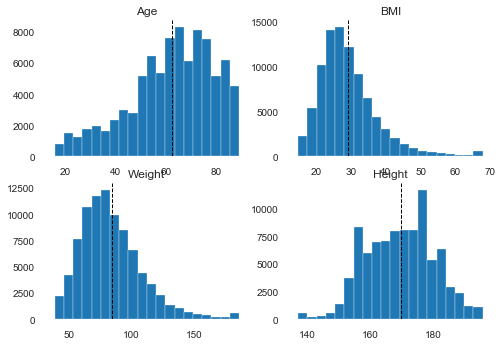

In [17]:
# Plot age, bmi, weight, height as histograms
fig = plt.figure()

plt.subplot(2, 2, 1)
plt.hist(df['age'], bins= 20)
plt.axvline(df['age'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.title('Age')

plt.subplot(2, 2, 2)
plt.hist(df['bmi'], bins= 20)
plt.axvline(df['bmi'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.title('BMI')

plt.subplot(2, 2, 3)
plt.hist(df['weight'], bins= 20)
plt.axvline(df['weight'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.title('Weight')

plt.subplot(2, 2, 4)
plt.hist(df['height'], bins= 20)
plt.axvline(df['height'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.title('Height')

plt.show()

# Error is from nan in data. Leave it for now. 

In [18]:
df['age'].agg([np.median,np.mean])

median    65.000000
mean      62.309516
Name: age, dtype: float64

#### Ethnicity (1.5% missing) and Gender (.02% missing)
* Replace ethnicity with most likely
    - Caucasian is by far the most represented ethnicity. But it is not the highest to pass. Look into this further.
* Drop rows missing gender

                  count   sum
ethnicity                    
African American   9547   750
Asian              1129    93
Caucasian         70684  6168
Hispanic           3796   376
Native American     788    70
Other/Unknown      4374   353


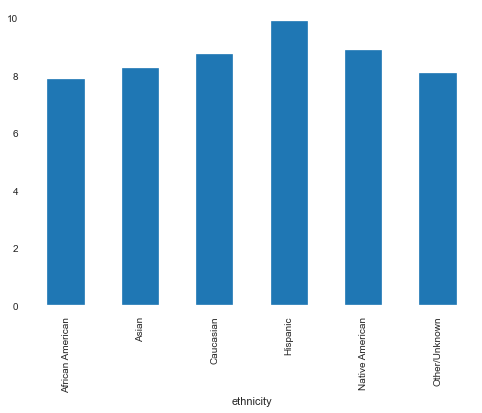

In [19]:
# This is probably where pivot_table and melting is useful. But easier for now to make a separate dataframe.
df_et = df.groupby('ethnicity').hospital_death.agg(['count','sum'])
print(df_et)
df_et['percent'] = df_et.iloc[:,1]/df_et.iloc[:,0]*100
df_et['percent'].plot(kind='bar')
plt.show()

### Address NaN - 

* hospital_admit_source (23%) and icu_admit_source (0.1%)
    - Drop hospital_admit_source and drop row with missing icu_admit source
* numeric: age, bmi, weight, height 
    - NaN are replaced. Take full columns into df_out
* categorical: ethnicity, gender
    - Replace missing ethnicity, drop missing gender

In [20]:
# Drop hospital_admit_source 
df = df.drop(columns = ['hospital_admit_source'])

# Drop row with missing icu_admit
df = df.dropna(subset = ['icu_admit_source'],axis=0)

In [21]:
# Replace NA
# Replace Age with mean
df['age'] = df['age'].fillna(df['age'].mean(skipna =True))

# Replace BMI with median
df['bmi'] = df['bmi'].fillna(df['bmi'].median(skipna =True))

# Replace Weight with median
df['weight'] = df['weight'].fillna(df['weight'].median(skipna =True))

# Replace Height with mean
df['height'] = df['height'].fillna(df['height'].mean(skipna =True))

In [22]:
# Replace ethnicity with most common
df['ethnicity'] = df['ethnicity'].fillna('Caucasian')

# Drop rows missing gender
df = df.dropna(subset = ['gender'],axis=0)
df.shape

(91576, 185)

### Apache

* Apache 4
    * Apache 4 still has missing data in both 'apache_4a_icu_death_prob' and 'apache_4a_hospital_death_prob'
    * Apache 4 has >2000 cases of probability = -1. -1 does not necessarily mean survive or not. However! icu and hospital have different places they are -1. 
* Apache 3
    * Appears twice - bodysystem (category) and diagnosis (numeric)
* Apache 2
    * Appears twice - bodysystem (category) and diagnosis (numeric)  

In [23]:
df[df['apache_4a_icu_death_prob'] == -1]['hospital_death'].count()

2145

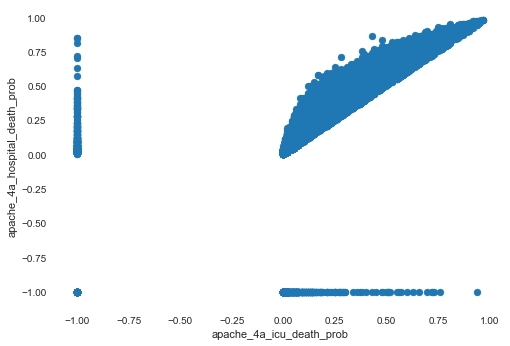

In [24]:
# Look at Apache
plt.scatter(df.apache_4a_icu_death_prob, df.apache_4a_hospital_death_prob)
plt.xlabel('apache_4a_icu_death_prob')
plt.ylabel('apache_4a_hospital_death_prob')
plt.show()

In [25]:
# Replace these two columns that are highly correlated with an average. If one value is -1, use only the other value. If both values are -1, set to NaN. 
apache_4 = []

for i in range(len(df)):
    
    if (df.iloc[i]['apache_4a_icu_death_prob'] == -1):
        apache_4.append(df.iloc[i]['apache_4a_hospital_death_prob'])
        
    elif (df.iloc[i]['apache_4a_hospital_death_prob'] == -1):
        apache_4.append(df.iloc[i]['apache_4a_icu_death_prob'])
        
    else:
        apache_4.append(np.mean((df.iloc[i]['apache_4a_icu_death_prob'],df.iloc[i]['apache_4a_hospital_death_prob'])))

In [26]:
# Make a new column...
df['apache4'] = apache_4

#...and drop the other ones
df = df.drop(columns = ['apache_4a_hospital_death_prob','apache_4a_icu_death_prob'])

#### Check the distributions of the apache4.

* Our '-1' follows the same trend as the data. I can't set it to 0 because that would change the probability of surviving from 0.3 to 3%. Instead, setting it 9% (and then adding that data into the exisitn 9% data) doesn't change. 
* The mean is close (affected by the -1) and easier to do on the test set. Set 'NA' and '-1' to mean of Apache4. 

In [27]:
# Well that didn't do much. Fixed  321 rows. 
print('Apache4 = -1', df[df['apache4'] == -1]['hospital_death'].agg([sum,len]))
print('Apache4 = 0', df[df['apache4'] == 0.09]['hospital_death'].agg([sum,len]))

Apache4 = -1 sum     168
len    1824
Name: hospital_death, dtype: int64
Apache4 = 0 sum     85
len    979
Name: hospital_death, dtype: int64


In [28]:
# Comparing data
print('Apache 4 = -1 died' , 168/1824*100)
print('Apache 4 = 0 died' , 85/979*100)
print('Apache 4 = 0 died' , (168+85)/(1824+979)*100)
print(df['apache4'].mean())

Apache 4 = -1 died 9.210526315789473
Apache 4 = 0 died 8.682328907048008
Apache 4 = 0 died 9.026043524794861
0.07146295255969973


In [40]:
# Set the mean and then change both -1 and NaN to the same value...
fillVal = df['apache4'].mean()
# First fillNA
df['apache4'] = df['apache4'].fillna(fillVal)
# Then update -1
df['apache4'] = df['apache4'].replace(-1, fillVal)
min(df['apache4'])

0.0

#### Apache 3 and 2
* Have both a Bodysystem (category) and diagnosis (numeric)

In [30]:
df['apache_3j_bodysystem'].value_counts(dropna=False)

Cardiovascular          29950
Neurological            11888
Sepsis                  11726
Respiratory             11595
Gastrointestinal         9015
Metabolic                7638
Trauma                   3833
Genitourinary            2168
NaN                      1646
Musculoskeletal/Skin     1166
Hematological             638
Gynecological             313
Name: apache_3j_bodysystem, dtype: int64

In [31]:
df['apache_3j_diagnosis'].agg([np.mean,max, min])

mean     558.432001
max     2201.050000
min        0.010000
Name: apache_3j_diagnosis, dtype: float64

In [32]:
df['apache_2_bodysystem'].value_counts(dropna=False)

Cardiovascular         38753
Neurologic             11888
Respiratory            11595
Gastrointestinal        9015
Metabolic               7638
Trauma                  3833
Undefined diagnoses     3767
Renal/Genitourinary     2457
NaN                     1646
Haematologic             638
Undefined Diagnoses      346
Name: apache_2_bodysystem, dtype: int64

In [33]:
df['apache_2_diagnosis'].agg([np.mean,max, min])

mean    185.414089
max     308.000000
min     101.000000
Name: apache_2_diagnosis, dtype: float64

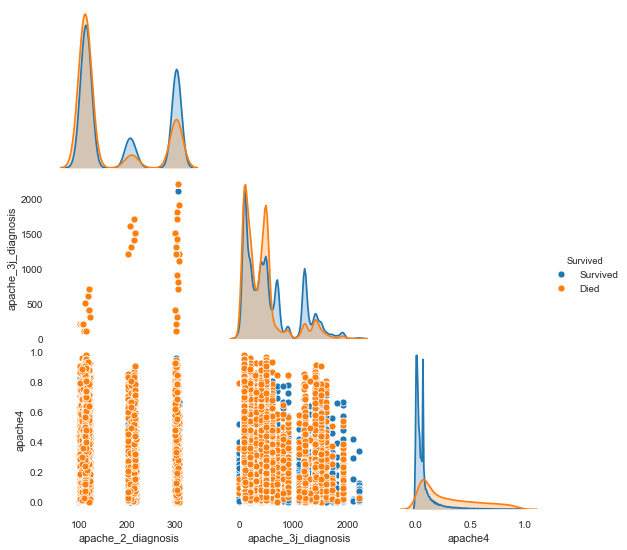

In [41]:
import seaborn as sns
g = sns.pairplot(df, vars=['apache_2_diagnosis','apache_3j_diagnosis','apache4'],hue='Survived',corner=True)

In [53]:
df[df['apache_2_diagnosis'].isna()]['apache_3j_bodysystem']

44       NaN
83       NaN
136      NaN
218      NaN
255      NaN
        ... 
91597    NaN
91625    NaN
91689    NaN
91693    NaN
91707    NaN
Name: apache_3j_bodysystem, Length: 1646, dtype: object

In [54]:
# Drop rows where apache 2 and 3 are missing..there is also missing data in other columns
# Drop rows missing gender
df = df.dropna(subset = ['apache_2_diagnosis'],axis=0)
df.shape


(89930, 184)

### Save the df. 

#### Leave vitals and other sections as is for now. They have a lot of NaN but they can be dropped or used to make new features next. 

In [61]:
savepath = os.path.join(maindir,'data/interim')
df.to_csv(os.path.join(savepath,'TrainingData_Cleaned.csv'))